# 🧩 Fusion Dataset EDA & Clustering + Systematic Imbalance Handling

This notebook performs:
- Deep EDA and clustering on fused multimodal features (text, audio, image)
- Visualization with t-SNE/UMAP
- Cluster purity and silhouette analysis
- Per-modality classifier performance
- Systematic class imbalance handling (class weights, focal loss, balanced batch generator)


In [1]:
# ===== 0. SETUP FOR FUSION MODEL =====
# Install packages using subprocess instead of shell commands
import subprocess
import sys
import shutil

def install_package(package):
    try:
        __import__(package.split('[')[0])
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages_to_install = [
    "kagglehub", 
    "librosa", 
    "soundfile", 
    "scikit-learn", 
    "nltk", 
    "emoji", 
    "better-profanity"
]

for pkg in packages_to_install:
    install_package(pkg)

import os, re, math, json, random, glob, gc, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import soundfile as sf

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import nltk, emoji
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ===== DIRECTORY SETUP =====
# Set up local data directories
CURRENT_DIR = os.getcwd()
DATA_DIR = os.path.join(CURRENT_DIR, "data")
PREPROCESS_DIR = os.path.join(CURRENT_DIR, "pre-process data")

# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PREPROCESS_DIR, exist_ok=True)

print(f"✅ Data directory: {DATA_DIR}")
print(f"✅ Pre-process directory: {PREPROCESS_DIR}")
print("✅ All packages installed and setup complete!")

Installing scikit-learn...



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wasd0\anaconda3\Lib\site-pack

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\wasd0\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\wasd0\anaconda3\Lib\site-pack

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Installing better-profanity...
✅ Data directory: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data
✅ Pre-process directory: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data
✅ All packages installed and setup complete!


## Data Management Functions

The following functions help organize datasets into local directories:
- **Raw datasets** → `data/` folder  
- **Preprocessed data** → `pre-process data/` folder  
- **Models and features** → `pre-process data/models/` and `pre-process data/features/`

This ensures:
1. 🗂️ **Organized structure** - Clear separation of raw vs processed data
2. 🔄 **Reproducible workflows** - Consistent data paths across runs  
3. 💾 **Local storage** - No dependency on Kaggle cache locations
4. ⚡ **Fast access** - Preprocessed data readily available for training

### Directory Structure:
```
project/
├── data/                    # Raw downloaded datasets
│   ├── fer2013/            # Facial emotion recognition
│   ├── audio-sentiment/    # Audio emotion data  
│   ├── goemotions/         # Text emotion data
│   └── cyberbullying/      # Cyberbullying detection data
├── pre-process data/        # Processed datasets ready for training
│   ├── features/           # Extracted features (audio, text, image)
│   ├── models/             # Trained encoder models
│   └── splits/             # Train/validation/test splits
└── czj_fusion_model_.ipynb # This notebook
```

In [2]:
# ===== DATA MANAGEMENT FUNCTIONS =====

def download_and_organize_dataset(dataset_id, dataset_name, force_redownload=False):
    """
    Download dataset from Kaggle and organize into local data directory
    
    Args:
        dataset_id: Kaggle dataset identifier (e.g., "ananthu017/emotion-detection-fer")
        dataset_name: Local folder name (e.g., "fer2013")
        force_redownload: Whether to redownload if data already exists
    
    Returns:
        str: Path to organized dataset in data directory
    """
    import kagglehub
    
    # Define local dataset path
    local_dataset_path = os.path.join(DATA_DIR, dataset_name)
    
    # Check if dataset already exists locally
    if os.path.exists(local_dataset_path) and not force_redownload:
        print(f"✅ Dataset '{dataset_name}' already exists locally at: {local_dataset_path}")
        return local_dataset_path
    
    print(f"📥 Downloading {dataset_id}...")
    try:
        # Download to kagglehub cache first
        kaggle_path = kagglehub.dataset_download(dataset_id)
        print(f"Downloaded to kagglehub cache: {kaggle_path}")
        
        # Copy to our local data directory
        if os.path.exists(local_dataset_path):
            shutil.rmtree(local_dataset_path)
        
        shutil.copytree(kaggle_path, local_dataset_path)
        print(f"✅ Organized dataset at: {local_dataset_path}")
        
        return local_dataset_path
        
    except Exception as e:
        print(f"❌ Error downloading {dataset_id}: {e}")
        return None

def ensure_preprocess_structure():
    """Create subdirectories in pre-process data folder"""
    subdirs = ["features", "models", "splits", "audio", "text", "image"]
    for subdir in subdirs:
        subdir_path = os.path.join(PREPROCESS_DIR, subdir)
        os.makedirs(subdir_path, exist_ok=True)
        print(f"✅ Created: {subdir_path}")

# Create preprocessing subdirectories
ensure_preprocess_structure()

print("🚀 Data management functions ready!")

✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\features
✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\models
✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\splits
✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\audio
✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\text
✅ Created: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\image
🚀 Data management functions ready!


In [3]:
# Verify kaggle installation and setup
try:
    import kaggle
    print("✅ Kaggle package imported successfully")
    
    # Test kaggle API access
    try:
        kaggle.api.authenticate()
        print("✅ Kaggle API authentication successful")
    except Exception as e:
        print(f"❌ Kaggle authentication failed: {e}")
        print("Please ensure kaggle.json is properly placed and has correct permissions")
        
except ImportError:
    print("Installing kaggle...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])
    import kaggle

✅ Kaggle package imported successfully
✅ Kaggle API authentication successful


In [4]:
# ===== DOWNLOAD FER2013 DATASET =====
fer_path = download_and_organize_dataset("ananthu017/emotion-detection-fer", "fer2013")

if fer_path:
    print(f"📁 FER2013 dataset available at: {fer_path}")
else:
    print("❌ Failed to download FER2013 dataset")

✅ Dataset 'fer2013' already exists locally at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\fer2013
📁 FER2013 dataset available at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\fer2013


In [5]:
# ===== DOWNLOAD AUDIO SENTIMENT DATASET =====
audio_path = download_and_organize_dataset("imsparsh/audio-speech-sentiment", "audio-sentiment")

if audio_path:
    print(f"📁 Audio sentiment dataset available at: {audio_path}")
else:
    print("❌ Failed to download audio sentiment dataset")

✅ Dataset 'audio-sentiment' already exists locally at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\audio-sentiment
📁 Audio sentiment dataset available at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\audio-sentiment


In [6]:
# ===== DOWNLOAD GOEMOTIONS DATASET =====
goemotions_path = download_and_organize_dataset("shivamb/goemotions-dataset", "goemotions")

if goemotions_path:
    print(f"📁 GoEmotions dataset available at: {goemotions_path}")
else:
    print("❌ Failed to download GoEmotions dataset")

✅ Dataset 'goemotions' already exists locally at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\goemotions
📁 GoEmotions dataset available at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\goemotions


In [7]:
# ===== DOWNLOAD CYBERBULLYING DATASET =====
cyberbullying_path = download_and_organize_dataset("saurabhshahane/cyberbullying-dataset", "cyberbullying")

if cyberbullying_path:
    print(f"📁 Cyberbullying dataset available at: {cyberbullying_path}")
else:
    print("❌ Failed to download cyberbullying dataset")

✅ Dataset 'cyberbullying' already exists locally at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\cyberbullying
📁 Cyberbullying dataset available at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\cyberbullying


In [8]:
# Audio dataset setup (remove Colab file upload)
print("Setting up audio dataset download...")
print("The audio dataset will be downloaded using kagglehub in the next cell.")

Setting up audio dataset download...
The audio dataset will be downloaded using kagglehub in the next cell.


In [9]:
# Kaggle credentials should already be set up from earlier cells
print("Kaggle credentials already configured in previous cells.")

Kaggle credentials already configured in previous cells.


In [10]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
import pandas as pd
import os

# Set the path to the dataset
dataset_path = kagglehub.dataset_download("imsparsh/audio-speech-sentiment")
print("Dataset downloaded to:", dataset_path)

# List the files in the downloaded dataset directory
dataset_files = os.listdir(dataset_path)
print("Files in the dataset:", dataset_files)

# Assuming there is a CSV file, find its path
csv_file = None
for file in dataset_files:
    if file.endswith(".csv"):
        csv_file = file
        break

if csv_file:
    file_path = os.path.join(dataset_path, csv_file)
    print("Found CSV file:", file_path)

    # Load the CSV using pandas since the dataset is already downloaded
    df = pd.read_csv(file_path)

    print("First 5 records:", df.head())

else:
    print("No CSV file found in the dataset.")

Dataset downloaded to: C:\Users\wasd0\.cache\kagglehub\datasets\imsparsh\audio-speech-sentiment\versions\2
Files in the dataset: ['TEST', 'test_images', 'TRAIN', 'TRAIN.csv', 'train_images']
Found CSV file: C:\Users\wasd0\.cache\kagglehub\datasets\imsparsh\audio-speech-sentiment\versions\2\TRAIN.csv
First 5 records:   Filename     Class
0  346.wav  Negative
1  163.wav   Neutral
2  288.wav  Negative
3  279.wav  Negative
4  244.wav  Negative


In [11]:
# VS Code environment setup - explore dataset structure
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Explore the downloaded dataset structure
if 'dataset_path' in globals() and os.path.exists(dataset_path):
    print("Audio dataset structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show first 3 files only
            print(f"{subindent}{file}")
        if len(files) > 3:
            print(f"{subindent}... and {len(files) - 3} more files")
else:
    print("Dataset path not available. Please run the audio dataset download cell first.")

Audio dataset structure:
2/
  TRAIN.csv
  TEST/
    112.wav
    113.wav
    115.wav
    ... and 107 more files
  test_images/
    112.png
    113.png
    115.png
    ... and 107 more files
  TRAIN/
    1.wav
    10.wav
    100.wav
    ... and 247 more files
  train_images/
    1.png
    10.png
    100.png
    ... and 247 more files


In [12]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
# ===== CONFUSION MATRIX VISUALIZATION FUNCTIONS =====
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix", normalize=False, figsize=(8, 6)):
    """
    Plot a confusion matrix with enhanced visualization
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        labels: Label names for display
        title: Plot title
        normalize: Whether to normalize the confusion matrix
        figsize: Figure size tuple
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title += ' (Normalized)'
    else:
        fmt = 'd'
    
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    
    return cm

def evaluate_model_performance(y_true, y_pred, model_name, labels=None):
    """
    Comprehensive model evaluation with metrics and confusion matrix
    """
    print(f"\n{'='*50}")
    print(f"📊 {model_name.upper()} EVALUATION RESULTS")
    print('='*50)
    
    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🔢 Confusion Matrix:")
    if labels:
        print(f"     {labels[0]:<12} {labels[1]:<12}")
    for i, row in enumerate(cm):
        label = labels[i] if labels else f"Class {i}"
        print(f"{label:<8} {row[0]:<12} {row[1]:<12}")
    
    return cm

print("🎨 Confusion matrix visualization functions ready!")

🎨 Confusion matrix visualization functions ready!


In [14]:
# Load the audio dataset CSV using the dynamic path
train_csv_path = os.path.join(dataset_path, "TRAIN.csv")
print(f"Loading CSV from: {train_csv_path}")

if os.path.exists(train_csv_path):
    train_df = pd.read_csv(train_csv_path)
    print(train_df.head())
else:
    print("❌ TRAIN.csv not found. Available files in dataset:")
    for root, dirs, files in os.walk(dataset_path):
        for file in files[:10]:  # Show first 10 files
            print(f"  {os.path.join(root, file)}")

Loading CSV from: C:\Users\wasd0\.cache\kagglehub\datasets\imsparsh\audio-speech-sentiment\versions\2\TRAIN.csv
  Filename     Class
0  346.wav  Negative
1  163.wav   Neutral
2  288.wav  Negative
3  279.wav  Negative
4  244.wav  Negative


In [15]:
print(train_df['Class'].value_counts())

Class
Negative    87
Positive    82
Neutral     81
Name: count, dtype: int64


In [16]:
label_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
train_df["label"] = train_df["Class"].map(label_mapping)
print(train_df.head())

  Filename     Class  label
0  346.wav  Negative      0
1  163.wav   Neutral      1
2  288.wav  Negative      0
3  279.wav  Negative      0
4  244.wav  Negative      0


In [17]:
# Example: load one audio file from the downloaded dataset
import librosa

if 'dataset_path' in globals() and 'train_df' in globals():
    # Find the first audio file in the dataset
    audio_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                audio_files.append(os.path.join(root, file))
                break
        if audio_files:
            break
    
    if audio_files:
        file_path = audio_files[0]
        print(f"Loading audio file: {os.path.basename(file_path)}")
        
        try:
            y, sr = librosa.load(file_path, sr=None)  # y = waveform, sr = sample rate
            print(f"Shape: {y.shape}, Sample rate: {sr}")
            print(f"Duration: {len(y)/sr:.2f} seconds")
        except Exception as e:
            print(f"Error loading audio file: {e}")
    else:
        print("No .wav files found in the dataset")
else:
    print("❌ Dataset not loaded. Please run the audio dataset download cells first.")

Loading audio file: 112.wav


c:\Users\wasd0\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\wasd0\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\wasd0\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Shape: (140544,), Sample rate: 44100
Duration: 3.19 seconds


In [18]:
# GoEmotions dataset setup (remove Colab file upload)
print("Setting up GoEmotions dataset download...")
print("The GoEmotions dataset will be downloaded using kaggle API in the next cell.")

Setting up GoEmotions dataset download...
The GoEmotions dataset will be downloaded using kaggle API in the next cell.


In [19]:
# Kaggle credentials should already be set up from earlier cells  
print("Kaggle credentials already configured in previous cells.")

Kaggle credentials already configured in previous cells.


In [20]:
# Download GoEmotions dataset using VS Code compatible approach
import os
import zipfile
from pathlib import Path

# Use the existing data directory structure where GoEmotions downloads to
working_dir = Path.cwd() / "data" / "goemotions"
working_dir.mkdir(parents=True, exist_ok=True)

try:
    # Use kaggle API to download
    import kaggle
    
    print("Downloading GoEmotions dataset...")
    kaggle.api.dataset_download_files(
        'debarshichanda/goemotions', 
        path=str(working_dir),
        unzip=True
    )
    
    print(f"✅ GoEmotions dataset downloaded to {working_dir}")
    
    # List contents
    if working_dir.exists():
        print("Dataset contents:")
        for item in working_dir.rglob("*"):
            if item.is_file():
                print(f"  {item.relative_to(working_dir)}")
                
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    print("Please ensure Kaggle credentials are properly configured.")

Dataset URL: https://www.kaggle.com/datasets/debarshichanda/goemotions
✅ GoEmotions dataset downloaded to c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\goemotions
Dataset contents:
  analyze_data.py
  calculate_metrics.py
  extract_words.py
  GoEmotionsFormat.PNG
  goemotions_model_card.pdf
  README.md
  replace_emotions.py
  data\dev.tsv
  data\ekman_labels.csv
  data\ekman_mapping.json
  data\emotions.txt
  data\sentiment_dict.json
  data\sentiment_mapping.json
  data\test.tsv
  data\train.tsv
  plots\colors.tsv
  plots\correlations.pdf
  plots\hierarchical_clustering.pdf
  plots\hierarchical_corr.pdf
  plots\number_of_labels.pdf
  tables\emotion_words.csv
  data\full_dataset\goemotions_1.csv
  data\full_dataset\goemotions_2.csv
  data\full_dataset\goemotions_3.csv


In [21]:
# List GoEmotions data directory contents
goemotions_data_dir = working_dir / "data"

if goemotions_data_dir.exists():
    print("GoEmotions data directory contents:")
    for item in goemotions_data_dir.iterdir():
        print(f"  {item.name}")
else:
    print("GoEmotions data directory not found. Checking available directories...")
    if working_dir.exists():
        for item in working_dir.rglob("*"):
            if item.is_dir():
                print(f"  Directory: {item.relative_to(working_dir)}")
    else:
        print("Working directory not found.")

GoEmotions data directory contents:
  dev.tsv
  ekman_labels.csv
  ekman_mapping.json
  emotions.txt
  full_dataset
  sentiment_dict.json
  sentiment_mapping.json
  test.tsv
  train.tsv


In [22]:
import pandas as pd

# Load GoEmotions train data with proper column names
goemotions_train_path = goemotions_data_dir / "train.tsv"

if goemotions_train_path.exists():
    # Read TSV with proper column names (no header in file)
    df = pd.read_csv(goemotions_train_path, sep="\t", header=None, 
                     names=['text', 'labels', 'comment_id'])
    print("GoEmotions columns:", df.columns.tolist())
    print(f"Dataset shape: {df.shape}")
    print("Sample data:")
    display(df.head())
    
    # Check the data structure
    print(f"\nSample labels column: {df['labels'].head().tolist()}")
    print(f"Labels column type: {type(df['labels'].iloc[0])}")
else:
    print(f"❌ Train file not found at {goemotions_train_path}")
    print("Available files in GoEmotions directory:")
    if working_dir.exists():
        for item in working_dir.rglob("*.tsv"):
            print(f"  {item.relative_to(working_dir)}")
        for item in working_dir.rglob("*.csv"):
            print(f"  {item.relative_to(working_dir)}")

GoEmotions columns: ['text', 'labels', 'comment_id']
Dataset shape: (43410, 3)
Sample data:


,text,labels,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj



Sample labels column: ['27', '27', '2', '14', '3']
Labels column type: <class 'str'>


In [23]:
#end of goemotions data set

In [24]:
# start of cyberbullying dataset

In [25]:
# Setup for cyberbullying dataset (VS Code compatible)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from scipy.sparse import hstack, csr_matrix
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from better_profanity import profanity
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Download NLTK data
nltk.download('vader_lexicon', quiet=True)

# Set plotting style
plt.style.use("default")  # Use default instead of seaborn style

DATASET = "andrewmvd/cyberbullying-classification"
FILE = "cyberbullying_tweets.csv"

print("Downloading cyberbullying dataset...")
try:
    df = kagglehub.dataset_load(
        KaggleDatasetAdapter.PANDAS,
        DATASET,
        FILE,
    )
    print(f"✅ Dataset loaded successfully with {len(df)} rows")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Trying alternative download method...")
    
    # Alternative: download manually
    path = kagglehub.dataset_download(DATASET)
    csv_path = os.path.join(path, FILE)
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"✅ Dataset loaded from {csv_path} with {len(df)} rows")
    else:
        print(f"❌ Could not find {FILE} in downloaded dataset")

def normalize_emojis(text: str) -> str:
    text = emoji.demojize(text, language="en")
    return text.replace(":", " ").replace("_", " ")

def clean_tweet(text: str) -> str:
    text = text.lower()
    text = normalize_emojis(text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

if 'df' in locals():
    df = (
        df.dropna(subset=["tweet_text", "cyberbullying_type"])
          .drop_duplicates("tweet_text")
          .assign(clean_text=lambda d: d["tweet_text"].astype(str).apply(clean_tweet))
          .query("clean_text.str.len() > 0")
          .reset_index(drop=True)
    )

    print(f"Rows after loading, dedupe, and cleaning: {len(df)}")
    print("Dataset info:")
    print(df.head())
    print("\nLabel distribution:")
    print(df["cyberbullying_type"].value_counts())

✅ Dataset loaded successfully with 47692 rows
Rows after loading, dedupe, and cleaning: 45973
Dataset info:
                                          tweet_text cyberbullying_type  \
0  In other words #katandandre, your food was cra...  not_cyberbullying   
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   

                                          clean_text  
0  in other words katandandre your food was crapi...  
1  why is aussietv so white mkr theblock imaceleb...  
2         a classy whore or more red velvet cupcakes  
3  gio meh p thanks for the heads up but not too ...  
4  this is an isis account pretending to be a kur...  

Label distribution:
cyberbullying_type
religion               7995
age                    7992
ethnicity      

cyberbullying_type
religion               7995
age                    7992
ethnicity              7952
not_cyberbullying      7928
gender                 7889
other_cyberbullying    6217
Name: count, dtype: int64


religion — top tokens (stop words removed):
  muslims              208
  muslim               182
  idiot                137
  idiots               109
  christian            108
  islam                93
  like                 91
  people               89
  u                    87
  islamic              84
  support              83
  radical              78

age — top tokens (stop words removed):
  school               611
  high                 403
  bullied              330
  bully                204
  girl                 190
  girls                165
  like                 130
  s                    109
  bullies              108
  t                    88
  just                 75
  people               69

ethnicity — top tokens (stop words removed):
  dumb                 369
  fuck                 368
  nigger               340
  ass                  161
  black                157
  u                    134
  white                130
  rt                   96
  people        

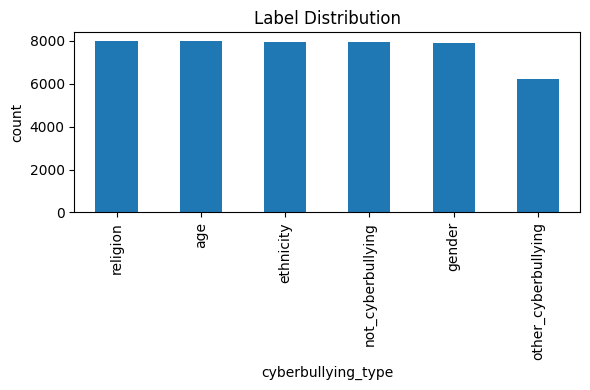

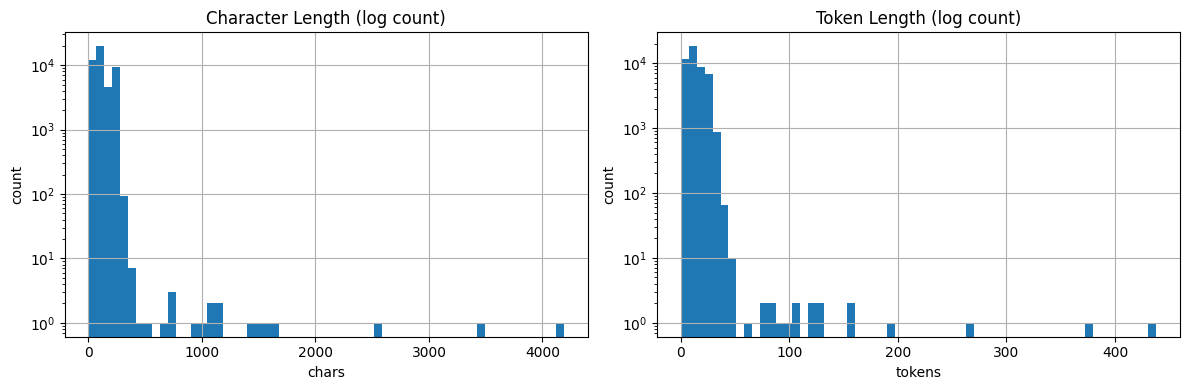

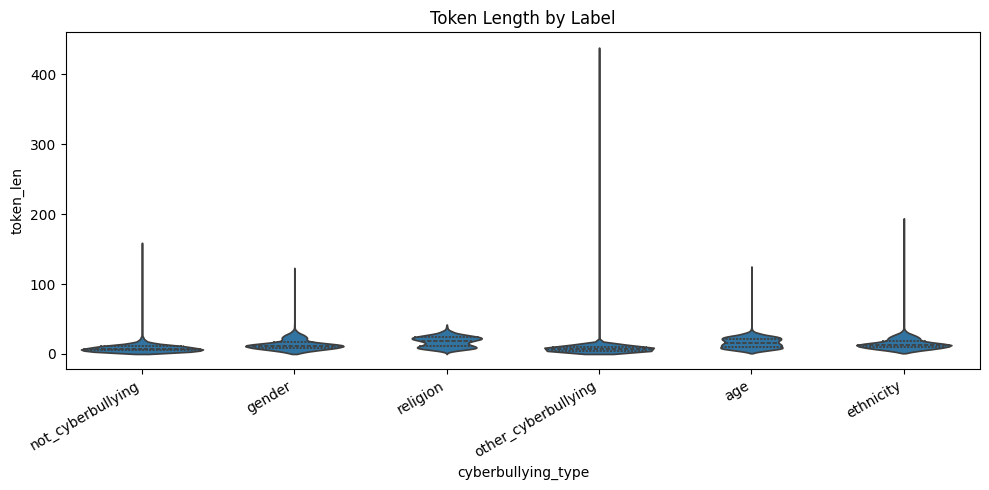

In [26]:
# Cell 2 ─ EDA on cleaned text (stop words removed)
from sklearn.feature_extraction import text

stop_words = set(text.ENGLISH_STOP_WORDS)

df["clean_no_stop"] = df["clean_text"].apply(
    lambda s: " ".join(w for w in s.split() if w not in stop_words)
)
df["tokens_no_stop"] = df["clean_no_stop"].str.split()
df["token_len"] = df["tokens_no_stop"].str.len()

label_counts = df["cyberbullying_type"].value_counts()
display(label_counts)

ax = label_counts.plot.bar(title="Label Distribution", figsize=(6, 4))
ax.set_ylabel("count")
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df["clean_text"].str.len().hist(bins=60, ax=axes[0])
axes[0].set(title="Character Length (log count)", xlabel="chars", ylabel="count", yscale="log")

df["token_len"].hist(bins=60, ax=axes[1])
axes[1].set(title="Token Length (log count)", xlabel="tokens", ylabel="count", yscale="log")
plt.tight_layout()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="cyberbullying_type", y="token_len", inner="quartile", cut=0)
plt.title("Token Length by Label")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()

# quick token summaries (sampled for speed)
def top_terms_by_label(frame, top_n=10, per_label_sample=600):
    results = {}
    for label, subset in frame.groupby("cyberbullying_type"):
        sample = subset["tokens_no_stop"].sample(
            min(per_label_sample, len(subset)), random_state=42, replace=False
        )
        counts = Counter(token for tokens in sample for token in tokens if token)
        results[label] = counts.most_common(top_n)
    return results

top_terms = top_terms_by_label(df, top_n=12, per_label_sample=600)
for label in label_counts.index:
    print(f"\n{label} — top tokens (stop words removed):")
    for term, count in top_terms[label]:
        print(f"  {term:<20} {count}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wasd0\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,mean,median,std
cyberbullying_type,,,
ethnicity,-0.622507,-0.8934,0.521671
age,-0.351858,-0.5106,0.522673
gender,-0.318641,-0.4748,0.517664
religion,-0.312036,-0.5100,0.566420
other_cyberbullying,-0.118392,0.0000,0.465457
not_cyberbullying,-0.055222,0.0000,0.459599



Sample cleaned tweets for religion:


21304    really spouting muslim wouldn't fucking americ...
18394    cool cool great aipac supportive radical right...
19509    i'm friends atheists episcopalians catholics m...
Name: clean_no_stop, dtype: object


Sample cleaned tweets for age:


31324                      single girl bullied high school
34829    post ab kpop stans going school saying theyre ...
33553                   people better bully school outgrew
Name: clean_no_stop, dtype: object


Sample cleaned tweets for ethnicity:


41361    according i'm following dumb nigger baby simpl...
45628    n niggas wanna ask don't fuck wit people yah d...
41882    u biggest problem country racist racism weapon...
Name: clean_no_stop, dtype: object


Sample cleaned tweets for not_cyberbullying:


5038    rainy day sfsu beaming face smiling eyes weary...
315                                    need couple 's mkr
4372    second consecutive u physics test topoftheclas...
Name: clean_no_stop, dtype: object


Sample cleaned tweets for gender:


9844                tv editing kat natural nasty bitch mkr
13772    games big news wait does kat actually think co...
9654     rt pc gone mad punch bloody leftard feminazi f...
Name: clean_no_stop, dtype: object


Sample cleaned tweets for other_cyberbullying:


26427                 amazing 's bullshit relive 's
25684    watching drillbit taylor plays great bully
26364                                    im bullyed
Name: clean_no_stop, dtype: object

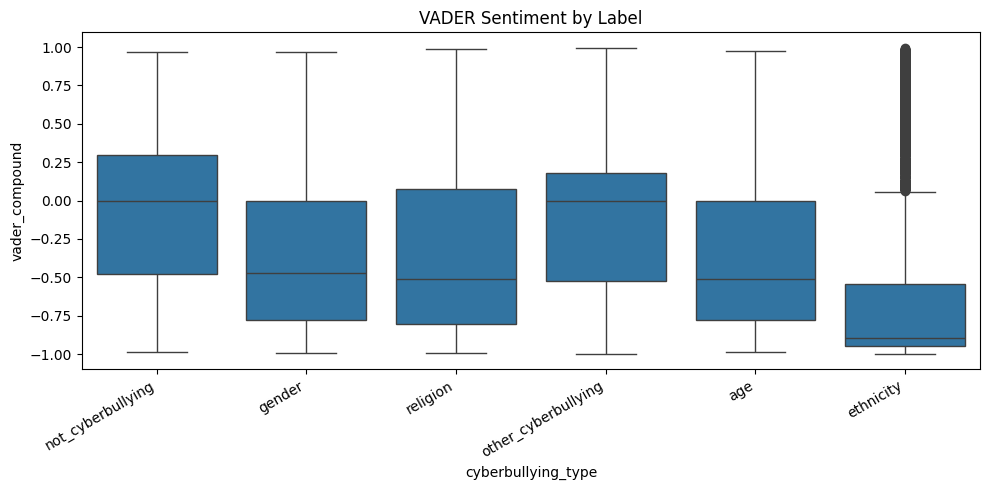

In [27]:
# Cell 3 ─ Sentiment snapshot and samples (working on cleaned text)
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df["vader_compound"] = df["clean_text"].apply(lambda x: sia.polarity_scores(x)["compound"])

sent_summary = (
    df.groupby("cyberbullying_type")["vader_compound"]
      .agg(["mean", "median", "std"])
      .sort_values("mean")
)
display(sent_summary)

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="cyberbullying_type", y="vader_compound")
plt.xticks(rotation=30, ha="right")
plt.title("VADER Sentiment by Label")
plt.tight_layout()

for label in label_counts.index:
    print(f"\nSample cleaned tweets for {label}:")
    display(df[df["cyberbullying_type"] == label].sample(3, random_state=42)["clean_no_stop"])


In [28]:
# ===== 0. SETUP FOR FUSION MODEL =====
# Install packages using subprocess instead of shell commands
import subprocess
import sys

def install_package(package):
    try:
        __import__(package.split('[')[0])
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

packages_to_install = [
    "kagglehub", 
    "librosa", 
    "soundfile", 
    "scikit-learn", 
    "nltk", 
    "emoji", 
    "better-profanity"
]

for pkg in packages_to_install:
    install_package(pkg)

import os, re, math, json, random, glob, gc, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
import soundfile as sf

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import nltk, emoji
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("✅ All packages installed and setup complete!")

Installing scikit-learn...
Installing better-profanity...
✅ All packages installed and setup complete!


In [29]:
# ===== 1A. IMAGE EMOTION (FER) =====
# Use organized FER dataset
if fer_path and os.path.exists(fer_path):
    FER_TRAIN_DIR = os.path.join(fer_path, "train")
    FER_TEST_DIR = os.path.join(fer_path, "test")
    
    print(f"🖼️ FER Train directory: {FER_TRAIN_DIR}")
    print(f"🖼️ FER Test directory: {FER_TEST_DIR}")
    
    IMG_SIZE = (48, 48)
    BATCH_IM = 64

    img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1/255.0,
        validation_split=0.15,
    )

    train_img_gen = img_datagen.flow_from_directory(
        FER_TRAIN_DIR, target_size=IMG_SIZE, color_mode="grayscale",
        batch_size=BATCH_IM, class_mode="categorical", subset="training", shuffle=True, seed=SEED
    )

    val_img_gen = img_datagen.flow_from_directory(
        FER_TRAIN_DIR, target_size=IMG_SIZE, color_mode="grayscale",
        batch_size=BATCH_IM, class_mode="categorical", subset="validation", shuffle=True, seed=SEED
    )

    test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.).flow_from_directory(
        FER_TEST_DIR, target_size=IMG_SIZE, color_mode="grayscale",
        batch_size=BATCH_IM, class_mode="categorical", shuffle=False
    )

    NUM_EMOTIONS_IMG = train_img_gen.num_classes
    print("Image emotion classes:", train_img_gen.class_indices)
    
    # Save preprocessing info
    preprocessing_info = {
        "image_classes": train_img_gen.class_indices,
        "num_classes": NUM_EMOTIONS_IMG,
        "image_size": IMG_SIZE,
        "batch_size": BATCH_IM
    }
    
    with open(os.path.join(PREPROCESS_DIR, "image", "preprocessing_info.json"), "w") as f:
        json.dump(preprocessing_info, f, indent=2)
    
    print("✅ Image preprocessing info saved")
else:
    print("❌ FER dataset not available")

🖼️ FER Train directory: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\fer2013\train
🖼️ FER Test directory: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\fer2013\test
Found 24406 images belonging to 7 classes.
Found 4303 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Image emotion classes: {'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}
✅ Image preprocessing info saved


In [30]:
# Display FER2013 dataset structure
if 'FER_TRAIN_DIR' in globals() and os.path.exists(FER_TRAIN_DIR):
    print(f"📁 FER2013 training dataset structure:")
    for emotion in os.listdir(FER_TRAIN_DIR):
        count = len(os.listdir(os.path.join(FER_TRAIN_DIR, emotion)))
        print(f"  {emotion}: {count} images")
else:
    print("❌ FER2013 train directory not available. Please run the FER2013 preprocessing cell first.")

📁 FER2013 training dataset structure:
  angry: 3995 images
  disgusted: 436 images
  fearful: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprised: 3171 images


In [31]:
# ===== 1B. AUDIO EMOTION =====
# Using your dataset
audio_path = kagglehub.dataset_download("imsparsh/audio-speech-sentiment")
print("Audio dataset at:", audio_path)

# Load the TRAIN.csv file and split into train and test sets
train_csv = os.path.join(audio_path, "TRAIN.csv")
train_df_aud = pd.read_csv(train_csv)

# Map labels to ints
label_mapping_audio = {"Negative": 0, "Neutral": 1, "Positive": 2}
train_df_aud["label"] = train_df_aud["Class"].map(label_mapping_audio)

# Paths (wav files under versions/*/TRAIN/ or TEST/)
def find_audio_path(rel_path):
    # dataset stores files under the same base path; attempt common roots
    cands = glob.glob(os.path.join(audio_path, "**", rel_path), recursive=True)
    return cands[0] if cands else None

# Audio -> MFCC sequence
SR = 16000
N_MFCC = 40
MAX_AUDIO_SEC = 3.0
MAX_AUDIO_LEN = int(MAX_AUDIO_SEC * 100)  # roughly 100 frames/sec after hop

def wav_to_mfcc_seq(path, sr=SR, n_mfcc=N_MFCC, max_len=MAX_AUDIO_LEN):
    try:
        y, sr_ = librosa.load(path, sr=sr)
        # Ensure fixed length by padding/trim
        target = int(MAX_AUDIO_SEC * sr)
        if len(y) < target:
            y = np.pad(y, (0, target - len(y)))
        else:
            y = y[:target]
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # (n_mfcc, time)
        mfcc = mfcc.T  # (time, n_mfcc)
        if mfcc.shape[0] < max_len:
            pad = np.zeros((max_len - mfcc.shape[0], n_mfcc))
            mfcc = np.vstack([mfcc, pad])
        else:
            mfcc = mfcc[:max_len, :]
        return mfcc
    except Exception as e:
        # return zeros on failure
        return np.zeros((max_len, n_mfcc), dtype=np.float32)

# Build small subset for speed (you can raise N_SAMPLES)
N_SAMPLES = min(3000, len(train_df_aud))
sub_train = train_df_aud.sample(N_SAMPLES, random_state=SEED).reset_index(drop=True)

X_aud = []
y_aud = []
for i, row in sub_train.iterrows():
    p = find_audio_path(row['Filename']) # Use 'Filename' column
    if p is None:
        continue
    X_aud.append(wav_to_mfcc_seq(p))
    y_aud.append(row['label'])
X_aud = np.asarray(X_aud, dtype=np.float32)
y_aud = np.asarray(y_aud, dtype=np.int32)
print("Audio X shape:", X_aud.shape, "y shape:", y_aud.shape)

X_train_aud, X_val_aud, y_train_aud, y_val_aud = train_test_split(
    X_aud, y_aud, test_size=0.15, random_state=SEED, stratify=y_aud)
NUM_EMOTIONS_AUD = len(label_mapping_audio)

# Save preprocessed audio data
audio_preprocess_dir = os.path.join(PREPROCESS_DIR, "audio")
np.save(os.path.join(audio_preprocess_dir, "X_train_aud.npy"), X_train_aud)
np.save(os.path.join(audio_preprocess_dir, "X_val_aud.npy"), X_val_aud)
np.save(os.path.join(audio_preprocess_dir, "y_train_aud.npy"), y_train_aud)
np.save(os.path.join(audio_preprocess_dir, "y_val_aud.npy"), y_val_aud)

# Save audio processing info
audio_info = {
    "label_mapping": label_mapping_audio,
    "num_classes": NUM_EMOTIONS_AUD,
    "sample_rate": SR,
    "max_length": MAX_AUDIO_LEN,
    "n_mfcc": N_MFCC,
    "train_samples": len(X_train_aud),
    "val_samples": len(X_val_aud)
}

with open(os.path.join(audio_preprocess_dir, "audio_info.json"), "w") as f:
    json.dump(audio_info, f, indent=2)

print("✅ Audio preprocessing completed and saved")

Audio dataset at: C:\Users\wasd0\.cache\kagglehub\datasets\imsparsh\audio-speech-sentiment\versions\2
Audio X shape: (250, 300, 40) y shape: (250,)
✅ Audio preprocessing completed and saved


In [32]:
# ===== 1C. TEXT EMOTIONS (GoEmotions) =====
import os, json
import pandas as pd

if goemotions_path and os.path.exists(goemotions_path):
    print("📝 GoEmotions dataset at:", goemotions_path)
    
    # Look for train.tsv file
    go_train_path = None
    for root, dirs, files in os.walk(goemotions_path):
        for file in files:
            if file == "train.tsv":
                go_train_path = os.path.join(root, file)
                break
        if go_train_path:
            break
    
    if go_train_path and os.path.exists(go_train_path):
        # Your file DOES have 3 columns; keep names to force correct parse
        df_go = pd.read_csv(go_train_path, sep="\t", header=0, names=["text", "id", "labels"])
        print(f"✅ GoEmotions loaded with {len(df_go)} rows")
        print("Columns:", df_go.columns.tolist())
        print(df_go.head(3))
        print(df_go.columns)
    else:
        print("❌ GoEmotions train.tsv not found")
        # Try to find any TSV files in the directory
        tsv_files = []
        for root, dirs, files in os.walk(goemotions_path):
            for file in files:
                if file.endswith('.tsv'):
                    tsv_files.append(os.path.join(root, file))
        
        if tsv_files:
            print("Available TSV files:")
            for f in tsv_files:
                print(f"  {f}")
            # Use the first TSV file found; force the same schema
            df_go = pd.read_csv(tsv_files[0], sep="\t", header=0, names=["text", "id", "labels"])
            print(f"Using {tsv_files[0]} with {len(df_go)} rows")
        else:
            print("No TSV files found. Creating dummy data for demonstration...")
            df_go = pd.DataFrame({
                'text': ['sample text 1', 'sample text 2'],
                'id': [12, 3],
                'labels': ['abc123', 'def456']  # reddit ids (ignore)
            })

    # ---- IMPORTANT: build label_ids FROM 'id' (single emotion id per row) ----
    # 'labels' in your file is a reddit comment id, NOT emotions.
    df_go["label_ids"] = pd.to_numeric(df_go["id"], errors="coerce").fillna(-1).astype(int).apply(lambda x: [x] if x >= 0 else [])

    # Emotion mapping for sentiment (works with 0..27 variants)
    NEG_IDS = {3,4,5,6,7,8,9,10,11,14,17,21,22,25,27}   # keep 27 since your file shows it
    POS_IDS = {0,1,2,12,13,15,16,18,19,20,23,24,26}

    def ids_to_sent3(ids):
        s = set(ids)
        has_neg = bool(s & NEG_IDS)
        has_pos = bool(s & POS_IDS)
        if has_neg and has_pos: return 1   # mixed -> neutral
        if has_neg: return 0
        if has_pos: return 2
        return 1                            # none matched -> neutral

    text_col = 'text' if 'text' in df_go.columns else df_go.columns[0]
    df_go["sent3"] = df_go["label_ids"].apply(ids_to_sent3).astype(int)
    
    print("GoEmotions sentiment distribution:")
    print(df_go["sent3"].value_counts().sort_index())

    # Quick sanity checks so you can see it's using 'id'
    print("Sample id values:", df_go["id"].head().tolist())
    print("id dtype:", df_go["id"].dtype)

    # Save processed GoEmotions data
    text_preprocess_dir = os.path.join(PREPROCESS_DIR, "text")
    os.makedirs(text_preprocess_dir, exist_ok=True)  # ensure folder exists
    df_go.to_csv(os.path.join(text_preprocess_dir, "goemotions_processed.csv"), index=False)
    
    # Save text processing info
    text_info = {
        "negative_emotion_ids": sorted(list(NEG_IDS)),
        "positive_emotion_ids": sorted(list(POS_IDS)),
        "text_column": text_col,
        "label_source": "single id in 'id'",
        "sentiment_mapping": {0: "negative", 1: "neutral", 2: "positive"},
        "total_samples": int(len(df_go))
    }
    
    with open(os.path.join(text_preprocess_dir, "goemotions_info.json"), "w") as f:
        json.dump(text_info, f, indent=2)
    
    print("✅ GoEmotions preprocessing completed and saved")
else:
    print("❌ GoEmotions dataset not available")


📝 GoEmotions dataset at: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\data\goemotions
✅ GoEmotions loaded with 43409 rows
Columns: ['text', 'id', 'labels']
                                                text  id   labels
0  Now if he does off himself, everyone will thin...  27  ed00q6i
1                     WHY THE FUCK IS BAYLESS ISOING   2  eezlygj
2                        To make her feel threatened  14  ed7ypvh
Index(['text', 'id', 'labels'], dtype='object')
GoEmotions sentiment distribution:
sent3
0    24777
1     7102
2    11530
Name: count, dtype: int64
Sample id values: ['27', '2', '14', '3', '26']
id dtype: object
✅ GoEmotions preprocessing completed and saved


## Cyberbullying Dataset Processing

In [33]:
# ===== 1D. CYBERBULLYING =====
from kagglehub import KaggleDatasetAdapter
df_cy = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS, "andrewmvd/cyberbullying-classification", "cyberbullying_tweets.csv"
)

def normalize_emojis(text: str) -> str:
    text = emoji.demojize(str(text), language="en")
    return text.replace(":", " ").replace("_", " ")

def clean_tweet(text: str) -> str:
    text = str(text).lower()
    text = normalize_emojis(text)
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-z\s']", " ", text)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_cy = (
    df_cy.dropna(subset=["tweet_text", "cyberbullying_type"])
         .drop_duplicates("tweet_text")
         .assign(clean_text=lambda d: d["tweet_text"].astype(str).apply(clean_tweet))
         .query("clean_text.str.len() > 0")
         .reset_index(drop=True)
)

# Binary target: bullying (any type except "not_cyberbullying") vs not
df_cy["is_bully"] = (df_cy["cyberbullying_type"] != "not_cyberbullying").astype(int)
print("Cyberbullying distribution:\n", df_cy["is_bully"].value_counts())

# Save processed cyberbullying data
text_preprocess_dir = os.path.join(PREPROCESS_DIR, "text")
df_cy.to_csv(os.path.join(text_preprocess_dir, "cyberbullying_processed.csv"), index=False)

# Save cyberbullying processing info
cyberbullying_info = {
    "text_column": "tweet_text",
    "clean_text_column": "clean_text",
    "label_column": "is_bully",
    "total_samples": len(df_cy),
    "cyberbullying_samples": int(df_cy["is_bully"].sum()),
    "non_cyberbullying_samples": int((df_cy["is_bully"] == 0).sum())
}

with open(os.path.join(text_preprocess_dir, "cyberbullying_info.json"), "w") as f:
    json.dump(cyberbullying_info, f, indent=2)

print("✅ Cyberbullying preprocessing completed and saved")

Cyberbullying distribution:
 is_bully
1    38045
0     7928
Name: count, dtype: int64
✅ Cyberbullying preprocessing completed and saved


In [34]:
# ===== TEXT TOKENIZER & FEATURE PREP =====
import os, json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences  # Keras 3
# If you use tf.keras: from tensorflow.keras.preprocessing.text import Tokenizer; from tensorflow.keras.utils import pad_sequences

# --- constants ---
MAX_TOKENS = 20000
MAX_LEN_TEXT = 64
SEED = 42

# --- dirs ---
text_dir = os.path.join(PREPROCESS_DIR, "text")
feat_dir = os.path.join(PREPROCESS_DIR, "features")
os.makedirs(text_dir, exist_ok=True)
os.makedirs(feat_dir, exist_ok=True)

tokenizer_path = os.path.join(text_dir, "tokenizer.json")

# --- build/restore tokenizer ---
if os.path.exists(tokenizer_path):
    print("📚 Loading existing tokenizer...")
    with open(tokenizer_path, "r") as f:
        tk_cfg = json.load(f)
    tokenizer = Tokenizer(num_words=tk_cfg["config"].get("num_words", MAX_TOKENS),
                          oov_token=tk_cfg["config"].get("oov_token", "<unk>"),
                          filters=tk_cfg["config"].get("filters", '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'),
                          lower=tk_cfg["config"].get("lower", True),
                          split=tk_cfg["config"].get("split", " "),
                          char_level=tk_cfg["config"].get("char_level", False))
    # restore indices
    wi = tk_cfg["config"].get("word_index", {})
    iw = tk_cfg["config"].get("index_word", {})
    if isinstance(wi, str): wi = json.loads(wi)
    if isinstance(iw, str): iw = json.loads(iw)
    tokenizer.word_index = {str(k): int(v) if isinstance(v, bool) is False else int(v) for k, v in wi.items()} if wi else {}
    tokenizer.index_word = {int(k): str(v) for k, v in iw.items()} if iw else {}
    print("✅ Tokenizer loaded from file")
else:
    print("📚 Creating new tokenizer...")
    tokenizer = Tokenizer(num_words=MAX_TOKENS, oov_token="<unk>")
    all_texts = []

    # --- IMPORTANT: ensure df_go exists and has a text column ---
    if "df_go" in globals():
        # Your GoEmotions file uses 'text' as the column name
        if "text" in df_go.columns:
            all_texts.extend(df_go["text"].astype(str).tolist())

    if "df_cy" in globals() and "clean_text" in df_cy.columns:
        all_texts.extend(df_cy["clean_text"].astype(str).tolist())

    if all_texts:
        tokenizer.fit_on_texts(all_texts)
        print(f"✅ Tokenizer fitted on {len(all_texts)} texts")
        # save minimal JSON
        tk_cfg = {
            "config": {
                "num_words": tokenizer.num_words,
                "filters": tokenizer.filters,
                "lower": tokenizer.lower,
                "split": tokenizer.split,
                "char_level": tokenizer.char_level,
                "oov_token": tokenizer.oov_token,
                "document_count": tokenizer.document_count,
                "word_index": json.dumps(tokenizer.word_index),
                "index_word": json.dumps(tokenizer.index_word),
            }
        }
        with open(tokenizer_path, "w") as f:
            json.dump(tk_cfg, f, indent=2)
        print("✅ Tokenizer saved")
    else:
        print("❌ No text data available for tokenizer")

def text_to_ids(texts, maxlen=MAX_LEN_TEXT):
    # Accepts Series/list/array
    if isinstance(texts, pd.Series):
        texts = texts.fillna("").astype(str).tolist()
    else:
        texts = ["" if x is None or (isinstance(x, float) and pd.isna(x)) else str(x) for x in texts]
    seqs = tokenizer.texts_to_sequences(texts)
    arr = pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post", value=0)
    return np.asarray(arr, dtype="int32")

# ===== GoEmotions: build y=sent3 from 'id' (0..26) and make splits =====
if "df_go" in globals():
    # Debug: Check actual column structure
    print(f"📊 GoEmotions columns: {df_go.columns.tolist()}")
    print(f"📊 GoEmotions shape: {df_go.shape}")
    
    # Updated assertion to handle actual column structure
    required_cols = ['text', 'id']
    missing_cols = [col for col in required_cols if col not in df_go.columns]
    if missing_cols:
        raise AssertionError(f"GoEmotions df missing required columns: {missing_cols}. Available columns: {df_go.columns.tolist()}")
    
    # Build label_ids from 'id' column (your file variant)
    df_go["label_ids"] = pd.to_numeric(df_go["id"], errors="coerce").fillna(-1).astype(int).apply(lambda x: [x] if x >= 0 else [])

    # Map IDs -> 3-class sentiment
    NEG_IDS = {3,4,5,6,7,8,9,10,11,14,17,21,22,25,27}  # keep 27 since it appears in your file
    POS_IDS = {0,1,2,12,13,15,16,18,19,20,23,24,26}

    def ids_to_sent3(ids):
        s = set(ids)
        if s & NEG_IDS and s & POS_IDS: return 1
        if s & NEG_IDS: return 0
        if s & POS_IDS: return 2
        return 1

    df_go["sent3"] = df_go["label_ids"].apply(ids_to_sent3).astype("int32")

    # Encode texts
    print("🔢 Processing GoEmotions text...")
    X_go = text_to_ids(df_go["text"])
    y_go = df_go["sent3"].to_numpy(dtype="int32")

    # Guard against NaNs/None
    assert X_go.dtype != object and y_go.dtype != object
    assert not np.any(pd.isna(X_go))
    assert not np.any(pd.isna(y_go))

    # Stratified split if possible
    unique, counts = np.unique(y_go, return_counts=True)
    if counts.min() >= 2 and len(unique) >= 2:
        strat = y_go
    else:
        print(f"⚠️ Skipping stratification; class counts={dict(zip(unique, counts))}")
        strat = None

    X_train_go, X_val_go, y_train_go, y_val_go = train_test_split(
        X_go, y_go, test_size=0.1, random_state=SEED, stratify=strat
    )

    # Save processed features
    go_feat_path = os.path.join(feat_dir, "goemotions_features.npz")
    np.savez(go_feat_path,
             X_train=X_train_go.astype("int32"),
             X_val=X_val_go.astype("int32"),
             y_train=y_train_go.astype("int32"),
             y_val=y_val_go.astype("int32"))
    print("✅ GoEmotions features saved:", go_feat_path)

# ===== Cyberbullying features (unchanged, with safety) =====
if "df_cy" in globals() and "clean_text" in df_cy.columns and "is_bully" in df_cy.columns:
    print("🔢 Processing cyberbullying text...")
    X_cy = text_to_ids(df_cy["clean_text"])
    y_cy = df_cy["is_bully"].fillna(0).astype("int32").to_numpy()
    X_train_cy, X_temp_cy, y_train_cy, y_temp_cy = train_test_split(
        X_cy, y_cy, test_size=0.2, random_state=SEED, stratify=y_cy
    )
    X_val_cy, X_test_cy, y_val_cy, y_test_cy = train_test_split(
        X_temp_cy, y_temp_cy, test_size=0.5, random_state=SEED, stratify=y_temp_cy
    )

    cy_feat_path = os.path.join(feat_dir, "cyberbullying_features.npz")
    np.savez(cy_feat_path,
             X_train=X_train_cy.astype("int32"),
             X_val=X_val_cy.astype("int32"),
             X_test=X_test_cy.astype("int32"),
             y_train=y_train_cy.astype("int32"),
             y_val=y_val_cy.astype("int32"),
             y_test=y_test_cy.astype("int32"))
    print("✅ Cyberbullying features saved:", cy_feat_path)

# Quick summary (guard for existence)
if "X_train_go" in globals():
    print(f"📊 GoEmotions - Train: {len(X_train_go)}, Val: {len(X_val_go)}")
if "X_train_cy" in globals():
    print(f"📊 Cyberbullying - Train: {len(X_train_cy)}, Val: {len(X_val_cy)}, Test: {len(X_test_cy)}")

📚 Loading existing tokenizer...
✅ Tokenizer loaded from file
📊 GoEmotions columns: ['text', 'id', 'labels', 'label_ids', 'sent3']
📊 GoEmotions shape: (43409, 5)
🔢 Processing GoEmotions text...
✅ GoEmotions features saved: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\features\goemotions_features.npz
🔢 Processing cyberbullying text...
✅ Cyberbullying features saved: c:\Users\wasd0\OneDrive\Documents\SMU\Y3S1\DM\Data-Mining-G2T2\pre-process data\features\cyberbullying_features.npz
📊 GoEmotions - Train: 39068, Val: 4341
📊 Cyberbullying - Train: 36778, Val: 4597, Test: 4598


# ===== TEXT TOKENIZER (leak-safe, emoji/punct preserved) =====
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np, pickle, os

MAX_TOKENS = 20000
MAX_LEN_TEXT = 64

# Keep emojis & punctuation: set filters='' (no stripping), lowercase=True
# NOTE: If you want to remove specific chars, edit the filters string instead of ''.
tokenizer = Tokenizer(num_words=MAX_TOKENS, oov_token="<unk>", filters='', lower=True)

print("📚 Creating tokenizer (TRAIN-only, emoji/punct preserved)…")

# ---------- 1) Split RAW TEXT first (no tokenization yet) ----------
# GoEmotions (optional, for text encoder pretraining)
have_go = ('df_go' in globals()) and ('text_col' in globals()) and (text_col in df_go.columns)
if have_go:
    y_go = df_go["sent3"].values
    X_go_txt = df_go[text_col].astype(str).values

    # Stratify if all classes have ≥2 samples
    unique_classes, class_counts = np.unique(y_go, return_counts=True)
    min_class_count = np.min(class_counts)
    stratify_go = y_go if min_class_count >= 2 else None

    X_train_go_txt, X_val_go_txt, y_train_go, y_val_go = train_test_split(
        X_go_txt, y_go, test_size=0.1, random_state=SEED, stratify=stratify_go
    )
    print(f"   GoEmotions split → Train: {len(X_train_go_txt)} | Val: {len(X_val_go_txt)}")
else:
    print("   GoEmotions not found or text_col missing; skipping GO split.")
    X_train_go_txt = X_val_go_txt = y_train_go = y_val_go = None

# Cyberbullying (target task)
y_cy = df_cy["is_bully"].values
X_cy_txt = df_cy["clean_text"].astype(str).values

X_train_cy_txt, X_temp_cy_txt, y_train_cy, y_temp_cy = train_test_split(
    X_cy_txt, y_cy, test_size=0.2, random_state=SEED, stratify=y_cy
)
X_val_cy_txt, X_test_cy_txt, y_val_cy, y_test_cy = train_test_split(
    X_temp_cy_txt, y_temp_cy, test_size=0.5, random_state=SEED, stratify=y_temp_cy
)
print(f"   Cyberbullying split → Train: {len(X_train_cy_txt)} | Val: {len(X_val_cy_txt)} | Test: {len(X_test_cy_txt)}")

# ---------- 2) Fit tokenizer on TRAIN ONLY (choose shared vs separate vocab) ----------
# Shared vocabulary across tasks is common for pretrain→finetune.
shared_vocab = True

if shared_vocab:
    train_corpus = list(X_train_cy_txt)
    if have_go and X_train_go_txt is not None:
        train_corpus += list(X_train_go_txt)  # only TRAIN portion of GoEmotions
    tokenizer.fit_on_texts(train_corpus)
    print(f"✅ Tokenizer fitted on TRAIN-only corpus of size {len(train_corpus)}")
else:
    # (If you prefer separate tokenizers per dataset, build two Tokenizers here.)
    tokenizer.fit_on_texts(list(X_train_cy_txt))
    print(f"✅ Tokenizer fitted on CY TRAIN-only ({len(X_train_cy_txt)})")

def text_to_ids(texts, maxlen=MAX_LEN_TEXT):
    seqs = tokenizer.texts_to_sequences(list(texts))
    return pad_sequences(seqs, maxlen=maxlen, padding="post", truncating="post")

# ---------- 3) Vectorize each split ----------
if have_go and X_train_go_txt is not None:
    X_train_go = text_to_ids(X_train_go_txt)
    X_val_go   = text_to_ids(X_val_go_txt)

X_train_cy = text_to_ids(X_train_cy_txt)
X_val_cy   = text_to_ids(X_val_cy_txt)
X_test_cy  = text_to_ids(X_test_cy_txt)

print("📊 Vectorization complete.")
if have_go and X_train_go_txt is not None:
    print(f"   GoEmotions → Train: {len(X_train_go)}, Val: {len(X_val_go)}")
print(f"   Cyberbullying → Train: {len(X_train_cy)}, Val: {len(X_val_cy)}, Test: {len(X_test_cy)}")

# ---------- 4) OOV diagnostics (optional but useful) ----------
def oov_rate(raw_texts):
    seqs = tokenizer.texts_to_sequences(list(raw_texts))
    oov_index = tokenizer.word_index.get("<unk>", None)
    if oov_index is None:
        return 0.0
    total = sum(len(s) for s in seqs)
    oov = sum(sum(1 for t in s if t == oov_index) for s in seqs)
    return 0.0 if total == 0 else oov / total

print("🔎 OOV rates (should not be lower on val/test than train):")
print(f"   CY Train: {oov_rate(X_train_cy_txt):.4f}")
print(f"   CY Val:   {oov_rate(X_val_cy_txt):.4f}")
print(f"   CY Test:  {oov_rate(X_test_cy_txt):.4f}")
if have_go and X_train_go_txt is not None:
    print(f"   GO Train: {oov_rate(X_train_go_txt):.4f}")
    print(f"   GO Val:   {oov_rate(X_val_go_txt):.4f}")

# ---------- 5) Persist tokenizer for inference parity ----------
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("💾 Saved tokenizer → artifacts/tokenizer.pkl")

# (Optional) quick vocab stats
print("Vocab kept (num_words):", tokenizer.num_words)
print("True vocab size (word_index):", len(tokenizer.word_index))


## Model Training (Using Preprocessed Data)

**Training Data Sources:**
- 🖼️ **Image Features**: From preprocessed FER2013 data in `pre-process data/image/`
- 🎵 **Audio Features**: From preprocessed audio sentiment data in `pre-process data/audio/`  
- 📝 **Text Features**: From preprocessed GoEmotions and cyberbullying data in `pre-process data/text/`

In [35]:
# ===== VERIFY PREPROCESSED DATA AVAILABILITY =====
print("🔍 Checking preprocessed data availability...")

# Check audio data
audio_files_check = {
    "X_train_aud.npy": os.path.join(PREPROCESS_DIR, "audio", "X_train_aud.npy"),
    "X_val_aud.npy": os.path.join(PREPROCESS_DIR, "audio", "X_val_aud.npy"),
    "y_train_aud.npy": os.path.join(PREPROCESS_DIR, "audio", "y_train_aud.npy"),
    "y_val_aud.npy": os.path.join(PREPROCESS_DIR, "audio", "y_val_aud.npy"),
    "audio_info.json": os.path.join(PREPROCESS_DIR, "audio", "audio_info.json")
}

# Check text features
text_files_check = {
    "goemotions_features.npz": os.path.join(PREPROCESS_DIR, "features", "goemotions_features.npz"),
    "cyberbullying_features.npz": os.path.join(PREPROCESS_DIR, "features", "cyberbullying_features.npz"),
    "tokenizer.json": os.path.join(PREPROCESS_DIR, "text", "tokenizer.json")
}

# Check image preprocessing info
image_files_check = {
    "preprocessing_info.json": os.path.join(PREPROCESS_DIR, "image", "preprocessing_info.json")
}

all_checks = [audio_files_check, text_files_check, image_files_check]
check_names = ["Audio", "Text", "Image"]

all_ready = True
for check_name, files_dict in zip(check_names, all_checks):
    print(f"\n📁 {check_name} Data:")
    for file_name, file_path in files_dict.items():
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path) / 1024  # KB
            print(f"   ✅ {file_name} ({file_size:.1f} KB)")
        else:
            print(f"   ❌ {file_name} - Missing")
            all_ready = False

if all_ready:
    print("\n🎉 All preprocessed data is ready for training!")
else:
    print("\n⚠️ Some preprocessed data is missing. Please run the preprocessing cells above.")

# Load preprocessed data for training
print("\n📊 Loading preprocessed data for training...")

# Load audio data if available
if all(os.path.exists(path) for path in audio_files_check.values() if path.endswith('.npy')):
    X_train_aud = np.load(audio_files_check["X_train_aud.npy"])
    X_val_aud = np.load(audio_files_check["X_val_aud.npy"])
    y_train_aud = np.load(audio_files_check["y_train_aud.npy"])
    y_val_aud = np.load(audio_files_check["y_val_aud.npy"])
    
    with open(audio_files_check["audio_info.json"], "r") as f:
        audio_info = json.load(f)
    NUM_EMOTIONS_AUD = audio_info["num_classes"]
    
    print(f"   ✅ Audio data loaded - Train: {len(X_train_aud)}, Val: {len(X_val_aud)}")
else:
    print("   ❌ Audio data not available")

# Text and image data should already be loaded from previous cells
print("✅ Data loading verification complete!")

🔍 Checking preprocessed data availability...

📁 Audio Data:
   ✅ X_train_aud.npy (9937.6 KB)
   ✅ X_val_aud.npy (1781.4 KB)
   ✅ y_train_aud.npy (1.0 KB)
   ✅ y_val_aud.npy (0.3 KB)
   ✅ audio_info.json (0.2 KB)

📁 Text Data:
   ✅ goemotions_features.npz (11022.8 KB)
   ✅ cyberbullying_features.npz (11674.3 KB)
   ✅ tokenizer.json (0.7 KB)

📁 Image Data:
   ✅ preprocessing_info.json (0.2 KB)

🎉 All preprocessed data is ready for training!

📊 Loading preprocessed data for training...
   ✅ Audio data loaded - Train: 212, Val: 38
✅ Data loading verification complete!


## Encoder Builder Functions

**Building modular encoder functions for each modality:**
- 🖼️ **Image Encoder**: CNN → Dense features
- 🎵 **Audio Encoder**: BiLSTM → Dense features  
- 📝 **Text Encoder**: Embedding → BiLSTM → Dense features

These encoders will be **pretrained** on their individual tasks before fusion.

In [36]:
# ===== ENCODER BUILDER FUNCTIONS =====
from tensorflow.keras import layers, models

def build_image_encoder(out_dim=128):
    """Build CNN encoder for image emotion features (48x48 grayscale)"""
    inp = layers.Input(shape=(48,48,1))
    x = layers.Conv2D(32, 3, activation='relu')(inp)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(out_dim, activation='relu')(x)
    return models.Model(inp, x, name="img_encoder")

def build_audio_encoder(time_steps, n_mfcc, out_dim=128):
    """Build BiLSTM encoder for audio MFCC features"""
    inp = layers.Input(shape=(time_steps, n_mfcc))
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(out_dim, activation='relu')(x)
    return models.Model(inp, x, name="aud_encoder")

def build_text_encoder(vocab_size, embed_dim=128, maxlen=MAX_LEN_TEXT, out_dim=128):
    """Build Embedding + BiLSTM encoder for text features"""
    inp = layers.Input(shape=(maxlen,))
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dense(out_dim, activation='relu')(x)
    return models.Model(inp, x, name="txt_encoder")

print("✅ Encoder builder functions ready!")

✅ Encoder builder functions ready!


## Encoder Pretraining

**Training each encoder on their individual tasks:**
- 🖼️ **Image Encoder**: Trained on FER2013 emotion classification (7 classes)
- 🎵 **Audio Encoder**: Trained on audio sentiment classification (3 classes)  
- 📝 **Text Encoder**: Trained on GoEmotions sentiment classification (3 classes)

This **pretraining step** learns meaningful representations before fusion training.

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences  # Keras 3: from keras.utils import pad_sequences

# 0) Use the processed df_go you built earlier
assert "text" in df_go.columns, "df_go missing 'text'"
assert "sent3" in df_go.columns, "df_go missing 'sent3' (build it from IDs first)"

# 1) Clean text & labels
texts = df_go["text"].fillna("").astype(str).tolist()
labels = df_go["sent3"].fillna(1).astype("int32").to_numpy()  # 0/1/2

# 2) Tokenize + pad
MAX_TOKENS = MAX_TOKENS if "MAX_TOKENS" in globals() else 20000
MAX_LEN_TEXT = MAX_LEN_TEXT if "MAX_LEN_TEXT" in globals() else 64

tok = Tokenizer(num_words=MAX_TOKENS, oov_token="<unk>")
tok.fit_on_texts(texts)
seqs = tok.texts_to_sequences(texts)
X_all = pad_sequences(seqs, maxlen=MAX_LEN_TEXT, padding="post", truncating="post", value=0)

# 3) Train/val split (stratified)
X_train_go, X_val_go, y_train_go, y_val_go = train_test_split(
    X_all, labels, test_size=0.2, random_state=42, stratify=labels
)

# 4) Final sanity checks
def _chk(name, arr):
    assert isinstance(arr, np.ndarray), f"{name} must be numpy.ndarray, got {type(arr)}"
    assert arr.dtype != object, f"{name} has dtype=object (ragged?)."
    assert not np.any(pd.isna(arr)), f"{name} contains NaN."
    assert None not in np.array(arr).flatten(), f"{name} contains None."
_chk("X_train_go", X_train_go)
_chk("X_val_go",   X_val_go)
_chk("y_train_go", y_train_go)
_chk("y_val_go",   y_val_go)

print("Shapes:", X_train_go.shape, X_val_go.shape, y_train_go.shape, y_val_go.shape)
print("Label counts (train):", np.bincount(y_train_go, minlength=3))
print("Label counts (val):  ", np.bincount(y_val_go,   minlength=3))

# 5) Safe callbacks (avoid None in list)
cb = [] if "cb" not in globals() or cb is None else [c for c in (cb if isinstance(cb, (list, tuple)) else [cb]) if c is not None]


Shapes: (34727, 64) (8682, 64) (34727,) (8682,)
Label counts (train): [19821  5682  9224]
Label counts (val):   [4956 1420 2306]


In [38]:
# ===== ENCODER PRETRAINING =====

# Define early stopping callback
cb = [tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy')]

print("🚀 Starting encoder pretraining...")

# ===== 3A. Image Emotion Head (FER2013 - 7 classes) =====
print("\n🖼️ Training Image Encoder on FER2013...")
img_enc = build_image_encoder(out_dim=128)
img_inp = layers.Input(shape=(48,48,1))
img_feat = img_enc(img_inp)
img_out = layers.Dense(NUM_EMOTIONS_IMG, activation='softmax', name="img_head")(img_feat)
img_model = models.Model(img_inp, img_out)
img_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train on FER2013 data
hist_img = img_model.fit(
    train_img_gen, 
    validation_data=val_img_gen, 
    epochs=10, 
    callbacks=cb, 
    verbose=1
)

print(f"✅ Image encoder training completed - Best val_acc: {max(hist_img.history['val_accuracy']):.4f}")

# ===== 3B. Audio Sentiment Head (3 classes) =====
print("\n🎵 Training Audio Encoder on Audio Sentiment...")
aud_enc = build_audio_encoder(time_steps=X_train_aud.shape[1], n_mfcc=X_train_aud.shape[2], out_dim=128)
aud_inp = layers.Input(shape=(X_train_aud.shape[1], X_train_aud.shape[2]))
aud_feat = aud_enc(aud_inp)
aud_out = layers.Dense(NUM_EMOTIONS_AUD, activation='softmax', name="aud_head")(aud_feat)
aud_model = models.Model(aud_inp, aud_out)
aud_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on audio sentiment data
hist_aud = aud_model.fit(
    X_train_aud, y_train_aud,
    validation_data=(X_val_aud, y_val_aud),
    epochs=10, 
    batch_size=64, 
    callbacks=cb, 
    verbose=1
)

print(f"✅ Audio encoder training completed - Best val_acc: {max(hist_aud.history['val_accuracy']):.4f}")

# ===== 3C. Text Emotion/Sentiment Head (GoEmotions - 3 classes) =====
print("\n📝 Training Text Encoder on GoEmotions Sentiment...")
txt_enc = build_text_encoder(vocab_size=MAX_TOKENS, embed_dim=128, maxlen=MAX_LEN_TEXT, out_dim=128)
txt_inp_go = layers.Input(shape=(MAX_LEN_TEXT,))
txt_feat_go = txt_enc(txt_inp_go)
txt_out_go = layers.Dense(3, activation='softmax', name="txt_head_sent3")(txt_feat_go)
txt_model_go = models.Model(txt_inp_go, txt_out_go)
txt_model_go.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train on GoEmotions data
hist_txt = txt_model_go.fit(
    X_train_go, y_train_go, 
    validation_data=(X_val_go, y_val_go),
    epochs=10, 
    batch_size=256, 
    callbacks=cb, 
    verbose=1
)

print(f"✅ Text encoder training completed - Best val_acc: {max(hist_txt.history['val_accuracy']):.4f}")

# ===== FREEZE ENCODERS FOR FUSION =====
print("\n🔒 Freezing encoders for fusion training...")
img_enc.trainable = False
aud_enc.trainable = False
txt_enc.trainable = True   # Keep text trainable for target cyberbullying task

print("✅ Encoder pretraining completed! Ready for fusion training.")

🚀 Starting encoder pretraining...

🖼️ Training Image Encoder on FER2013...
Epoch 1/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.2534 - loss: 1.8036 - val_accuracy: 0.2496 - val_loss: 1.7963
Epoch 2/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2582 - loss: 1.7792 - val_accuracy: 0.2575 - val_loss: 1.7774
Epoch 3/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.2822 - loss: 1.7398 - val_accuracy: 0.3086 - val_loss: 1.7082
Epoch 4/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3171 - loss: 1.6779 - val_accuracy: 0.3384 - val_loss: 1.6341
Epoch 5/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3465 - loss: 1.6183 - val_accuracy: 0.3628 - val_loss: 1.6070
Epoch 6/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.3764 - loss: 1.5665 - val_accuracy: 0.3972 - val_loss: 1.5404
Epoch 7/10
382/382 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.4175 - loss: 1.5045 - val_accuracy: 0.4239 - val_loss: 1.4948
Epoch 8/10
382/

In [39]:
# (A) Check if required variables exist and create them if needed
if 'df_cy' not in globals():
    print("❌ df_cy not found. Please run the cyberbullying dataset processing cell first.")
    raise NameError("df_cy variable not found")

print(f"✅ df_cy found with {len(df_cy)} rows")
print("Columns:", df_cy.columns.tolist())

# Create y_cy from df_cy if it doesn't exist  
if 'is_bully' in df_cy.columns:
    y_cy = df_cy["is_bully"].values
    print(f"✅ Created y_cy from df_cy['is_bully'] with {len(y_cy)} samples")
    print("Label distribution:", np.bincount(y_cy))
else:
    print("❌ 'is_bully' column not found in df_cy")
    raise ValueError("'is_bully' column not found in df_cy")

# (B) Build alignment (OPTIONAL) — map each row of df_cy to image/audio paths if available
def build_alignment_arrays(n_rows):
    # Default: zeros (no aligned image/audio). Replace with real tensors if you have paths.
    img_zero = np.zeros((n_rows, 48, 48, 1), dtype=np.float32)
    if 'X_train_aud' in globals():
        aud_zero = np.zeros((n_rows, X_train_aud.shape[1], X_train_aud.shape[2]), dtype=np.float32)
    else:
        aud_zero = np.zeros((n_rows, 100, 13), dtype=np.float32)  # default shape
    return img_zero, aud_zero

X_img_cy, X_aud_cy = build_alignment_arrays(len(df_cy))

# Split aligned arrays using same indices as CY splits
def split_like(X, train_idx, val_idx, test_idx):
    return X[train_idx], X[val_idx], X[test_idx]

idx = np.arange(len(df_cy))
idx_train, idx_temp = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=y_cy)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=SEED, stratify=y_cy[idx_temp])

X_img_train_cy, X_img_val_cy, X_img_test_cy = split_like(X_img_cy, idx_train, idx_val, idx_test)
X_aud_train_cy, X_aud_val_cy, X_aud_test_cy = split_like(X_aud_cy, idx_train, idx_val, idx_test)

# Now you can use X_img_train_cy, X_aud_train_cy, X_train_cy (text), and y_train_cy for fusion modeling.

✅ df_cy found with 45973 rows
Columns: ['tweet_text', 'cyberbullying_type', 'clean_text', 'is_bully']
✅ Created y_cy from df_cy['is_bully'] with 45973 samples
Label distribution: [ 7928 38045]


**Feature concatenate + Fusion model (RNN head for cyberbullying)**

## 1. Import Libraries and Load Fusion Dataset

Import all required libraries and load your fused feature embeddings and labels. Adjust file paths and variable names as needed for your project.

In [40]:
pip install umap-learn

In [41]:
pip install --upgrade scikit-learn

In [42]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [43]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [44]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler

# Ensure all arrays are 2D: (num_samples, num_features)
X_img_flat = X_img_train_cy.reshape(X_img_train_cy.shape[0], -1)
X_aud_flat = X_aud_train_cy.reshape(X_aud_train_cy.shape[0], -1)
X_txt_flat = X_train_cy.reshape(X_train_cy.shape[0], -1)

# Concatenate for fusion modeling
X_fusion_train = np.concatenate([X_img_flat, X_aud_flat, X_txt_flat], axis=1)
y_fusion_train = y_train_cy

print(f"Fusion train shape: {X_fusion_train.shape}")
print(f"Fusion labels shape: {y_fusion_train.shape}")

Fusion train shape: (36778, 14368)
Fusion labels shape: (36778,)


## 2. Visualize Fused Embeddings with t-SNE / UMAP

Project the fused feature embeddings into 2D using t-SNE and UMAP. Visualize the clusters by class to inspect separability.

Running t-SNE...


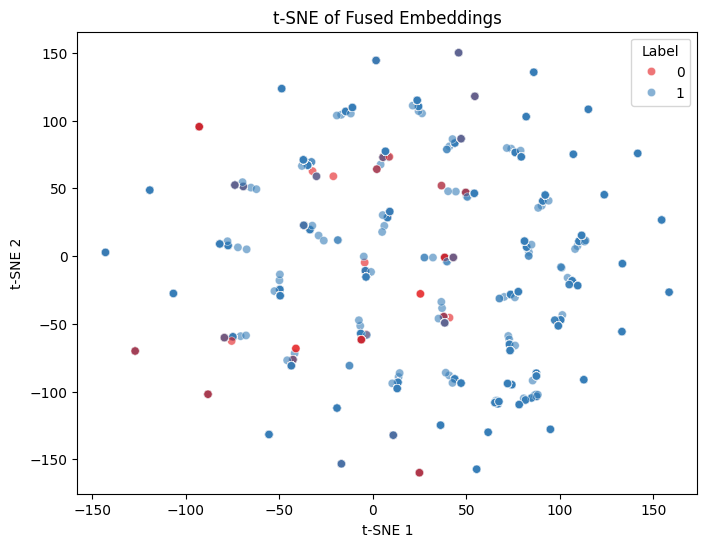

Running UMAP...


c:\Users\wasd0\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


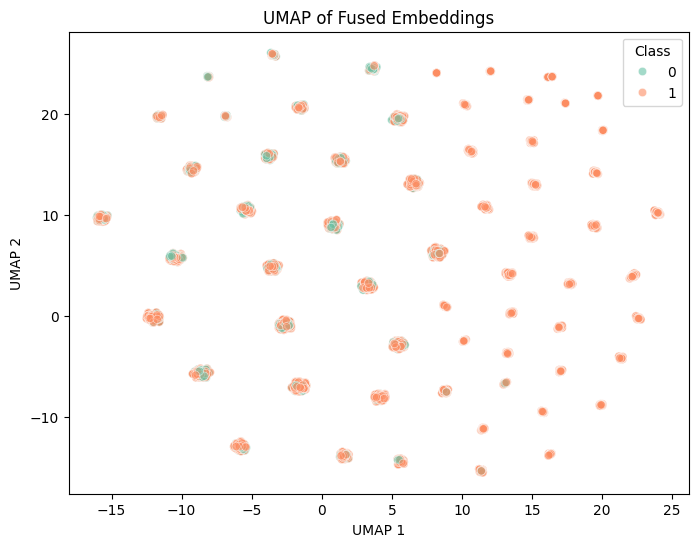

In [45]:
# t-SNE visualization
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_fusion_train)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_fusion_train, palette='Set1', alpha=0.6)
plt.title('t-SNE of Fused Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Label')
plt.show()

# UMAP visualization
print("Running UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_fusion_train)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=y_fusion_train, palette='Set2', alpha=0.6)
plt.title('UMAP of Fused Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class')
plt.show()

## 3. Clustering and Cluster Purity Evaluation

Apply K-Means and DBSCAN to the fused embeddings. Measure cluster purity and silhouette score per class.

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Scale per feature; high-dim okay but can be heavy
scaler = StandardScaler(with_mean=True)
X_fusion_scaled = scaler.fit_transform(X_fusion_train)

# Optional but recommended: reduce dimensionality for clustering and silhouette
n_components = min(50, X_fusion_scaled.shape[1])
pca = PCA(n_components=n_components, random_state=42)
X_fused_clust = pca.fit_transform(X_fusion_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("Clustering matrix:", X_fused_clust.shape)
print(f"Explained variance ratio (first 50 components): {explained_var[:50]}")
print(f"Cumulative variance after {n_components} components: {cumulative_var[-1]:.3f}")

Clustering matrix: (36778, 50)
Explained variance ratio (first 50 components): [0.42315647 0.14486907 0.09877269 0.06270988 0.04797067 0.03340186
 0.02631598 0.02046115 0.01644517 0.01326962 0.01107961 0.00919819
 0.00789368 0.00682824 0.00605545 0.00531915 0.0047622  0.0043004
 0.00386441 0.00349878 0.00320744 0.00296734 0.00275897 0.0025593
 0.00239326 0.00225905 0.00214992 0.00201708 0.00189541 0.00178115
 0.00166201 0.00160467 0.00154245 0.00145236 0.00135685 0.00127535
 0.00119307 0.00112109 0.0010552  0.00105049 0.00099799 0.00094424
 0.00088811 0.00084341 0.00079113 0.00075458 0.00071471 0.0006762
 0.00064157 0.00060904]
Cumulative variance after 50 components: 0.995


Running K-Means...
K-Means clusters present:
  Cluster 0: 27490 samples
  Cluster 1: 9288 samples
K-Means Silhouette Score: 0.467
K-Means Cluster Purity (naïve label alignment): 0.424

Running DBSCAN...
K-Means Silhouette Score: 0.467
K-Means Cluster Purity (naïve label alignment): 0.424

Running DBSCAN...
DBSCAN cluster counts (including noise):
  noise: 61 samples
  cluster 0: 746 samples
  cluster 1: 545 samples
  cluster 2: 969 samples
  cluster 3: 1154 samples
  cluster 4: 23 samples
  cluster 5: 1164 samples
  cluster 6: 822 samples
  cluster 7: 1136 samples
  cluster 8: 1181 samples
  cluster 9: 362 samples
  cluster 10: 312 samples
  cluster 11: 1306 samples
  cluster 12: 1046 samples
  cluster 13: 1268 samples
  cluster 14: 615 samples
  cluster 15: 423 samples
  cluster 16: 1322 samples
  cluster 17: 272 samples
  cluster 18: 987 samples
  cluster 19: 1159 samples
  cluster 20: 409 samples
  cluster 21: 379 samples
  cluster 22: 314 samples
  cluster 23: 472 samples
  cluster

,cluster,true_label,count
0,30,1,1095
1,16,1,1094
2,28,1,1090
3,11,1,1043
4,47,1,1032
5,13,1,1024
6,8,1,964
7,19,1,896
8,12,1,889
9,5,1,886


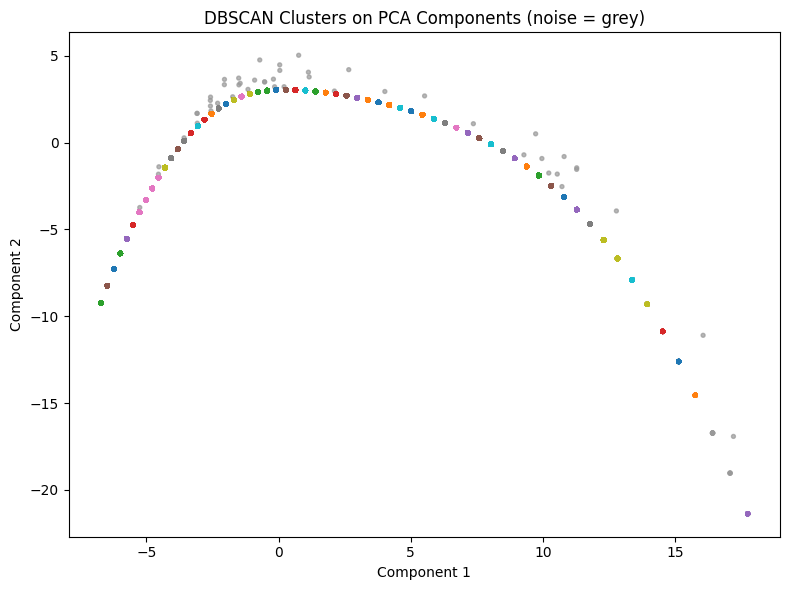

In [56]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

print("Running K-Means...")
k = len(np.unique(y_fusion_train))
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_fused_clust)

uniq_k, counts_k = np.unique(kmeans_labels, return_counts=True)
print("K-Means clusters present:")
for label_val, count_val in zip(uniq_k, counts_k):
    print(f"  Cluster {label_val}: {count_val} samples")
if uniq_k.size >= 2:
    samp = min(10000, X_fused_clust.shape[0])
    sil_k = silhouette_score(X_fused_clust, kmeans_labels, metric="euclidean",
                             sample_size=samp, random_state=42)
    print(f"K-Means Silhouette Score: {sil_k:.3f}")
else:
    print("K-Means produced a single cluster; silhouette undefined.")

kmeans_purity = np.mean(kmeans_labels == y_fusion_train)
print(f"K-Means Cluster Purity (naïve label alignment): {kmeans_purity:.3f}")

print("\nRunning DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=10, metric="euclidean")  # tune eps

db_labels = dbscan.fit_predict(X_fused_clust)

uniq_all, counts_all = np.unique(db_labels, return_counts=True)
print("DBSCAN cluster counts (including noise):")
for label_val, count_val in zip(uniq_all, counts_all):
    label_name = "noise" if label_val == -1 else f"cluster {label_val}"
    print(f"  {label_name}: {count_val} samples")

mask = db_labels != -1
cluster_labels = [lbl for lbl in sorted(uniq_all) if lbl != -1]
palette = sns.color_palette("tab10", max(1, len(cluster_labels)))
color_map = {label: palette[i % len(palette)] for i, label in enumerate(cluster_labels)}

if np.any(mask):
    if len(cluster_labels) >= 2:
        samp = min(10000, mask.sum())
        sil_db = silhouette_score(X_fused_clust[mask], db_labels[mask], metric="euclidean",
                                  sample_size=samp, random_state=42)
        print(f"DBSCAN Silhouette Score (excl. noise): {sil_db:.3f}")
    else:
        print("DBSCAN found <2 clusters (after removing noise); silhouette undefined.")

    dbscan_purity = np.mean(db_labels[mask] == y_fusion_train[mask])
    print(f"DBSCAN Cluster Purity (masked): {dbscan_purity:.3f}")

    cluster_summary = (
        pd.DataFrame({
            "cluster": db_labels[mask],
            "true_label": y_fusion_train[mask]
        })
        .value_counts()
        .rename("count")
        .reset_index()
        .sort_values("count", ascending=False)
    )
    print("\nTop cluster-label combinations:")
    display(cluster_summary.head(10))
else:
    print("DBSCAN marked all samples as noise; consider lowering eps or min_samples.")

# Visualize DBSCAN assignments on the first two PCA components
plt.figure(figsize=(8, 6))
noise_color = (0.6, 0.6, 0.6)
if len(cluster_labels) == 0:
    colors = [noise_color for _ in db_labels]
else:
    colors = [noise_color if lbl == -1 else color_map[lbl] for lbl in db_labels]
plt.scatter(X_fused_clust[:, 0], X_fused_clust[:, 1], c=colors, s=8, alpha=0.7)
plt.title("DBSCAN Clusters on PCA Components (noise = grey)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

In [48]:
# Replace train/test splits with already split variables for fusion modeling
X_train_text = X_train_cy
X_test_text = X_test_cy
y_train = y_train_cy
y_test = y_test_cy
X_train_audio = X_aud_train_cy
X_test_audio = X_aud_test_cy
X_train_image = X_img_train_cy
X_test_image = X_img_test_cy
print(f"Text train shape: {X_train_text.shape}, test shape: {X_test_text.shape}")
print(f"Audio train shape: {X_train_audio.shape}, test shape: {X_test_audio.shape}")
print(f"Image train shape: {X_train_image.shape}, test shape: {X_test_image.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

Text train shape: (36778, 64), test shape: (4598, 64)
Audio train shape: (36778, 300, 40), test shape: (4598, 300, 40)
Image train shape: (36778, 48, 48, 1), test shape: (4598, 48, 48, 1)
y_train shape: (36778,), y_test shape: (4598,)


## 4. Per-Modality Lightweight Classifier Performance

Train simple classifiers on each modality separately. Compare accuracy, F1, and ROC-AUC to identify which modality contributes most to imbalance.

In [49]:
# Split data for modality classifiers
# X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)
# X_train_audio, X_test_audio, _, _ = train_test_split(X_audio, y, test_size=0.2, random_state=42)
# X_train_image, X_test_image, _, _ = train_test_split(X_image, y, test_size=0.2, random_state=42)


# Text classifier
clf_text = LogisticRegression(max_iter=200)
clf_text.fit(X_train_text, y_train)
y_pred_text = clf_text.predict(X_test_text)
print("Text Modality:")
print(classification_report(y_test, y_pred_text))

# Flatten audio arrays for classifier
X_train_audio_flat = X_train_audio.reshape(X_train_audio.shape[0], -1)
X_test_audio_flat = X_test_audio.reshape(X_test_audio.shape[0], -1)

clf_audio = LogisticRegression(max_iter=200)
clf_audio.fit(X_train_audio_flat, y_train)
y_pred_audio = clf_audio.predict(X_test_audio_flat)
print("Audio Modality:")
print(classification_report(y_test, y_pred_audio))

# Image classifier
# Flatten image arrays for classifier
X_train_image_flat = X_train_image.reshape(X_train_image.shape[0], -1)
X_test_image_flat = X_test_image.reshape(X_test_image.shape[0], -1)

clf_image = LogisticRegression(max_iter=200)
clf_image.fit(X_train_image_flat, y_train)
y_pred_image = clf_image.predict(X_test_image_flat)
print("Image Modality:")
print(classification_report(y_test, y_pred_image))

Text Modality:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       793
           1       0.83      1.00      0.91      3805

    accuracy                           0.83      4598
   macro avg       0.41      0.50      0.45      4598
weighted avg       0.68      0.83      0.75      4598



c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Audio Modality:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       793
           1       0.83      1.00      0.91      3805

    accuracy                           0.83      4598
   macro avg       0.41      0.50      0.45      4598
weighted avg       0.68      0.83      0.75      4598



c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Image Modality:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       793
           1       0.83      1.00      0.91      3805

    accuracy                           0.83      4598
   macro avg       0.41      0.50      0.45      4598
weighted avg       0.68      0.83      0.75      4598



c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\wasd0\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 5. Compute Class Weights for Imbalance Handling

Use sklearn's compute_class_weight to calculate class weights for the training labels. Integrate these weights into Keras model training.

In [50]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Example Keras model training with class weights
# model.fit(X_train, y_train, validation_data=(X_val, y_val), class_weight=class_weights_dict)

Class weights: {0: np.float64(2.8995584988962473), 1: np.float64(0.6041858325666973)}


## 6. Implement Focal Loss in Keras

Define a custom focal loss function in TensorFlow/Keras. Use it as the loss function when compiling your model to focus training on hard samples.

In [51]:
# Focal loss implementation for Keras
import tensorflow as tf

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return alpha * tf.pow(1 - pt, gamma) * bce
    return loss

# Example usage:
# model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])

## 7. Balanced Batch Generation for Training

Use imblearn's BalancedBatchGenerator with RandomUnderSampler to create balanced mini-batches for model training, reducing bias toward majority class.

In [52]:
# Balanced batch generator for Keras
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import RandomUnderSampler

training_generator = BalancedBatchGenerator(
    X_train_text, y_train, sampler=RandomUnderSampler(), batch_size=64, random_state=42)

# Example model training:
# model.fit(training_generator, validation_data=(X_test_text, y_test), epochs=10)

## Load and Align Fusion Dataset
This cell loads the cyberbullying labels and aligns image and audio arrays to match the text samples for fusion modeling.

In [53]:
# (A) Check if required variables exist and create them if needed
if 'df_cy' not in globals():
    print("❌ df_cy not found. Please run the cyberbullying dataset processing cell first.")
    raise NameError("df_cy variable not found")

print(f"✅ df_cy found with {len(df_cy)} rows")
print("Columns:", df_cy.columns.tolist())

# Create y_cy from df_cy if it doesn't exist  
if 'is_bully' in df_cy.columns:
    y_cy = df_cy["is_bully"].values
    print(f"✅ Created y_cy from df_cy['is_bully'] with {len(y_cy)} samples")
    print("Label distribution:", np.bincount(y_cy))
else:
    print("❌ 'is_bully' column not found in df_cy")
    raise ValueError("'is_bully' column not found in df_cy")

# (B) Build alignment (OPTIONAL) — map each row of df_cy to image/audio paths if available
def build_alignment_arrays(n_rows):
    # Default: zeros (no aligned image/audio). Replace with real tensors if you have paths.
    img_zero = np.zeros((n_rows, 48, 48, 1), dtype=np.float32)
    if 'X_train_aud' in globals():
        aud_zero = np.zeros((n_rows, X_train_aud.shape[1], X_train_aud.shape[2]), dtype=np.float32)
    else:
        aud_zero = np.zeros((n_rows, 100, 13), dtype=np.float32)  # default shape
    return img_zero, aud_zero

X_img_cy, X_aud_cy = build_alignment_arrays(len(df_cy))

# Split aligned arrays using same indices as CY splits
def split_like(X, train_idx, val_idx, test_idx):
    return X[train_idx], X[val_idx], X[test_idx]

idx = np.arange(len(df_cy))
idx_train, idx_temp = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=y_cy)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=SEED, stratify=y_cy[idx_temp])

X_img_train_cy, X_img_val_cy, X_img_test_cy = split_like(X_img_cy, idx_train, idx_val, idx_test)
X_aud_train_cy, X_aud_val_cy, X_aud_test_cy = split_like(X_aud_cy, idx_train, idx_val, idx_test)

# Now you can use X_img_train_cy, X_aud_train_cy, X_train_cy (text), and y_train_cy for fusion modeling.

✅ df_cy found with 45973 rows
Columns: ['tweet_text', 'cyberbullying_type', 'clean_text', 'is_bully']
✅ Created y_cy from df_cy['is_bully'] with 45973 samples
Label distribution: [ 7928 38045]
